# Feature Transformations

We typically use neural networks (NNs) as a very complex, automated feature extraction. The hope this that the NN will be able to provide a feature representation that allows us to do learning. However, there are some tricky features which require a little bit of preprocessing. These include spatial and temporal (spatio-temporal) features. This notebook will go through some of the ways we can *help* our network by giving some informative features.

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = root.joinpath("experiments/dc_2021b/")

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm


# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Argumentsget_data_args

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"
args.feature_scaler = "standard"

args.smoke_test = False
args.wandb_mode = "disabled"
args.wandb_resume = True

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Transformations

**Coordinates**

* **Latitude**: `-90 =< lat <= 90`
* **Longtiude**: `-180 =< lon <= 180`

* Cartesian/Spherical


**Time**

* Cycle
* 

### Cartesian Coordinates


$$
\begin{aligned}
x &= r \cos(\lambda)\cos(\phi) \\
y &= r \cos(\lambda)\sin(\phi) \\
z &= r \sin(\lambda)
\end{aligned}
$$

where:

* $\phi \in [-90, 90]$ - longitude
* $\lambda \in [-180, 180]$ - latitude
* $r$ - radius

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import Pipeline

In [4]:
from inr4ssh._src.features.spatial import Spherical2Cartesian3D
from inr4ssh._src.features.temporal import TimeMinMaxScaler
from inr4ssh._src.features.

In [61]:
# create longitude coords
n_points = 100
buffer = 0.001 # to ensure we don't git the boundaries exactly

lon_min = 10

lon_coords = np.linspace(-(90-buffer), 90 - buffer, n_points)
lat_coords = np.linspace(-(180-buffer), 180-buffer, n_points)

# create grid
lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords)
lon_grid, lat_grid = lon_grid.ravel(), lat_grid.ravel()

assert lon_grid.shape[0] == n_points*n_points
assert lat_grid.shape[0] == n_points*n_points

# create dataframe
data = pd.DataFrame(
    {"longitude": lon_grid,
     "latitude": lat_grid,
    }
)
assert data.shape[0] == n_points*n_points

In [62]:
lon_grid.shape

(10000,)

In [7]:
spatial_transform = Pipeline([
    ("cartesian3d", Spherical2Cartesian3D(radius=1.0))
])

spatial_features = ["longitude", "latitude"]

In [64]:
data_ = spatial_transform.fit_transform(data)
data_.shape

(10000, 3)

In [65]:
data_.min(), data_.max()

(-0.9999999996953826, 0.9999999996953826)

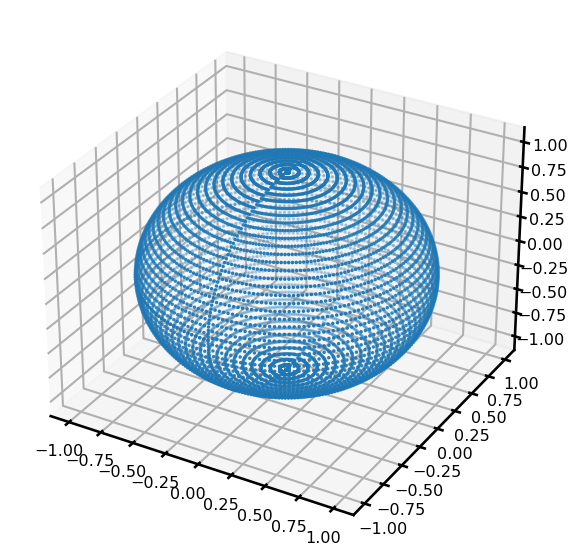

In [9]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(data_[:,0], data_[:,1], data_[:, 2], s=1.0)
plt.show()

### Column Transformer

Now we can use this as a part of a `scikit-learn` `pipeline`. This allows us to automate things a little bit.

In [59]:
scaler = ColumnTransformer(
    transformers=[
        ("cartesian3d", Spherical2Cartesian3D(radius=1.0), spatial_features),
    ],
    remainder="drop",
)

In [60]:
data_ = scaler.fit_transform(data)

In [12]:
data_.shape

(10000, 3)

## Temporal Coordinates

In [14]:
# from ml4ssh._src.features import TimeMinMaxScaler
from sklearn.preprocessing import minmax_scale, MinMaxScaler

In [15]:
time_coords = np.arange(
    "2010-01-01", 
    "2015-12-31", 
    dtype='datetime64[1h]'
)
df_ts = pd.DataFrame(
    {"time":time_coords}
)


In [16]:
df_ts.head()

,time
0,2010-01-01 00:00:00
1,2010-01-01 01:00:00
2,2010-01-01 02:00:00
3,2010-01-01 03:00:00
4,2010-01-01 04:00:00


In [17]:
df_ts.plot()

<AxesSubplot:>

### Scaling

So, the fourier feature methods and SIREN networks in general, we need to do some sort of scaling of the inputs.

**Absolute Time**

* `t0 = 2005-01-01`
* `t1 = 2022-01-01`

**Absolute Scale**

* `scale_min = -1.0`
* `scale_max = 1.0`

In [30]:
time_min = np.datetime64("2010-01-01")
time_max = np.datetime64("2015-12-30")
max_scale = 1.0
min_scale = -1.0

In [31]:
time_coords.min(), time_coords.max()

(numpy.datetime64('2010-01-01T00','h'), numpy.datetime64('2015-12-30T23','h'))

In [32]:
time_std = (time_coords - time_min) / (time_max - time_min)
time_scaled = time_std * (max_scale - min_scale) + min_scale

In [33]:
time_std

array([0.00000000e+00, 1.90345668e-05, 3.80691335e-05, ...,
       1.00039973e+00, 1.00041876e+00, 1.00043780e+00])

In [34]:
time_scaled

array([-1.        , -0.99996193, -0.99992386, ...,  1.00079945,
        1.00083752,  1.00087559])

In [35]:
temporal_transform = Pipeline([
    ("timestd", TimeMinMaxScaler(julian_date=True)),
    # ("minmax", MinMaxScaler(feature_range=(-1,1)))
])

temporal_features = ["time"]

In [36]:
df_ts_ = temporal_transform.fit_transform(df_ts)
df_ts_.shape

(52560, 1)

In [37]:
df_ts_.min(), df_ts_.max()

(0.2940892253180866, 0.6467963171740198)

In [ ]:
df_ts_

In [ ]:
data_.shape

In [ ]:
data_

## Putting Everything Together

So now, we are going to have a full spatio-temporal vector

$$
\mathbf{x} \in \mathbb{R}^{D_\phi}, \;\;\; D_\phi = \{ \text{lon, lat, time} \}
$$

And we are going to do some transformations on the spatial and temporal features independently.

In [38]:
# create dataframe
data = pd.DataFrame(
    {"longitude": lon_grid,
     "latitude": lat_grid,
     "time": df_ts.sample(n=lon_grid.shape[0], random_state=1).values[:, 0]
    }
)

In [39]:
data.head()

,longitude,latitude,time
0,-89.999000,-179.999,2011-05-16 01:00:00
1,-88.180838,-179.999,2013-04-26 17:00:00
2,-86.362677,-179.999,2015-02-19 22:00:00
3,-84.544515,-179.999,2010-08-23 03:00:00
4,-82.726354,-179.999,2012-12-05 05:00:00


In [40]:
from sklearn.compose import ColumnTransformer

In [41]:
spatial_features = ["longitude", "latitude"]
temporal_features = ["time"]

In [54]:
# spatial transform
spatial_transform = Pipeline([
    ("cartesian3d", Spherical2Cartesian3D(radius=1.0))
])

spatial_features = ["longitude", "latitude"]

# temporal transform
temporal_transform = Pipeline([
    ("timestd", TimeMinMaxScaler(julian_date=True)),
    ("minmax", MinMaxScaler(feature_range=(-1,1)))
])

temporal_features = ["time"]

In [55]:
scaler = ColumnTransformer(
    transformers=[
        ("cartesian3d", spatial_transform, spatial_features),
        ("timeminmax", temporal_transform, temporal_features),
    ],
    remainder="drop",
)

In [56]:
data_ = scaler.fit_transform(data)

In [57]:
assert data_.shape[1] == 4

In [58]:
data_[:, -1].min(), data_[:, -1].max()

(-1.0000000000000002, 0.9999999999999996)

### Cyclic Coordinates

In [ ]:
lon_max = 180
lon_min = -180
min_scale = -1
max_scale = 1

In [94]:

lon_std = (lon_coords - lon_min) / (lon_max - lon_min)
lon_coords_scaled = lon_std * (max_scale - min_scale) + min_scale
lon_coords_scaled.min(), lon_coords_scaled.max()

(-1.0, 1.0)

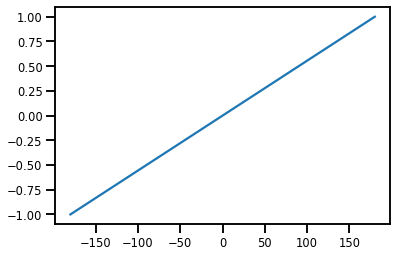

In [95]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled)
plt.show()

In [96]:
# scale between 
lon_coords_scaled_sin = np.sin(np.pi * lon_coords_scaled)
lon_coords_scaled_cos = np.cos(np.pi * lon_coords_scaled)

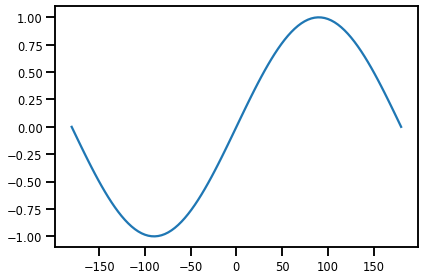

In [97]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled_sin)
plt.tight_layout()
plt.show()

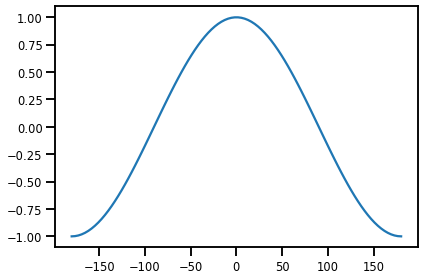

In [98]:
fig, ax = plt.subplots()
ax.plot(lon_coords, lon_coords_scaled_cos)
plt.tight_layout()
plt.show()

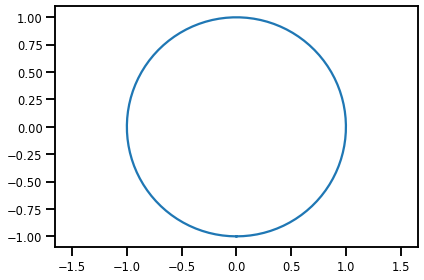

In [99]:
fig, ax = plt.subplots()
ax.plot(lon_coords_scaled_sin, lon_coords_scaled_cos)
plt.tight_layout()
plt.axis("equal")
plt.show()